This notebook does not reflect definitive results of our study and is solely for ad hoc exploration.

In [14]:
import sys
sys.path.append("..")
from utils import read_json
data = read_json("../../data/annotations.json")

import random
import numpy as np

In [15]:
srcs = list({line["source"] for user_line in data for line in user_line["lines"]})

src_to_n1 = {line["source"] : line["translations"]["4"]["orig"] for user_line in data for line in user_line["lines"]}
src_to_p1 = {line["source"] : line["translations"]["1"]["orig"] for user_line in data for line in user_line["lines"]}
src_to_p3 = {line["source"] : line["translations"]["3"]["orig"] for user_line in data for line in user_line["lines"]}
src_to_n1_pe = {line["source"]: line["translations"]["4"]["done"] for user_line in data for line in user_line["lines"]}
src_to_p1_pe = {line["source"]: line["translations"]["1"]["done"] for user_line in data for line in user_line["lines"]}
src_to_p3_pe = {line["source"]: line["translations"]["3"]["done"] for user_line in data for line in user_line["lines"]}

In [33]:
# mtme -t wmt20 -l en-cs --scores > ~/optimal-reference-translations/data/data_tmp/scores.tsv
# mtme -t wmt20 -l en-cs --echosys doc,src > ~/optimal-reference-translations/data/data_tmp/text.tsv
# remove first line fro mscores

with open("../../data/data_tmp/text.tsv", "r") as f:
    src_to_i = {
        l.removesuffix("\n").split("\t")[3]:i
        for i, l in enumerate(f.readlines())
    }

with open("../../data/data_tmp/scores.tsv", "r") as f:
    i_to_score = {
        i:float(l.split("\t")[5]) if l.split("\t")[5] != "None" else 0
        for i, l in enumerate(f.readlines())
    }

with open("../../data/data_tmp/text.tsv", "r") as f:
    tgts_all = [
        l.split("\t")[1]
        for i, l in enumerate(f.readlines())
    ]

    tgts = [
        tgts_all[src_to_i[s]]
        for s in srcs
    ]

with open("../../data/data_tmp/text.tsv", "r") as f:
    tgt_to_score = {
        l.split("\t")[1]:i_to_score[i]
        for i, l in enumerate(f.readlines())
    }

human = [
    tgt_to_score[tgt]
    for tgt in tgts
]

In [47]:
from comet import download_model, load_from_checkpoint

model_path = download_model("Unbabel/wmt22-comet-da")
model = load_from_checkpoint(model_path)

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 31022.96it/s]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.
/home/vilda/.local/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:255: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
  rank_zero_warn(


In [48]:
def get_scores(srcs, tgts, ref_map):
    refs = [ref_map[line] for line in srcs]
    batched = [
        {"ref": line[2], "src": line[0], "mt": line[1]}
        for line in zip(srcs, tgts, refs)
    ]
    scores = model.predict(batched, gpus=0, batch_size=10)["scores"]
    return np.array(scores)

comet_n1 = get_scores(srcs, tgts, src_to_n1)
comet_p1 = get_scores(srcs, tgts, src_to_p1_pe)
comet_p3 = get_scores(srcs, tgts, src_to_p3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 16/16 [01:16<00:00,  4.75s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 16/16 [02:27<00:00,  9.22s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 16/16 [02:21<00:00,  8.83s/it]


In [77]:
from evaluate import load

model_chrf = load("chrf")

def get_scores(srcs, tgts, ref_map):
    refs = [ref_map[line] for line in srcs]
    scores = [
        model_chrf.compute(predictions=[line[1]], references=[[line[2]]])["score"]
        for line in zip(srcs, tgts, refs)
    ]
    return np.array(scores)


def get_scores_all(srcs, tgts, ref_maps):
    refs = [[ref_map[line] for ref_map in ref_maps] for line in srcs]
    scores = [
        model_chrf.compute(predictions=[line[1]], references=[line[2]])["score"]
        for line in zip(srcs, tgts, refs)
    ]
    return np.array(scores)

chrf_n1 = get_scores(srcs, tgts, src_to_n1)
chrf_p1 = get_scores(srcs, tgts, src_to_p1_pe)
chrf_p3 = get_scores(srcs, tgts, src_to_p3)
chrf_n1_p1s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1])
chrf_n1s_p1s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1_pe])
chrf_n1_p1s_p3 = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1, src_to_p3])
chrf_n1_p1s_p3_n1s_p3s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1, src_to_p3, src_to_n1_pe, src_to_p3_pe])
chrf_p1s_p3 = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_p3])
chrf_n1_p3 = get_scores_all(srcs, tgts, [src_to_p3, src_to_n1])

In [76]:
from evaluate import load
model_bleu = load("sacrebleu")

def get_scores(srcs, tgts, ref_map):
    refs = [ref_map[line] for line in srcs]
    scores = [
        model_bleu.compute(predictions=[line[1]], references=[[line[2]]])["score"]
        for line in zip(srcs, tgts, refs)
    ]
    return np.array(scores)

def get_scores_all(srcs, tgts, ref_maps):
    refs = [[ref_map[line] for ref_map in ref_maps] for line in srcs]
    scores = [
        model_bleu.compute(predictions=[line[1]], references=[line[2]])["score"]
        for line in zip(srcs, tgts, refs)
    ]
    return np.array(scores)


bleu_n1 = get_scores(srcs, tgts, src_to_n1)
bleu_p1 = get_scores(srcs, tgts, src_to_p1_pe)
bleu_p3 = get_scores(srcs, tgts, src_to_p3)
bleu_n1_p1s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1])
bleu_n1s_p1s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1_pe])
bleu_n1_p1s_p3 = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1, src_to_p3])
bleu_n1_p1s_p3_n1s_p3s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1, src_to_p3, src_to_n1_pe, src_to_p3_pe])
bleu_p1s_p3 = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_p3])
bleu_n1_p3 = get_scores_all(srcs, tgts, [src_to_p3, src_to_n1])

In [75]:
from evaluate import load
model_bleu = load("ter")

def get_scores(srcs, tgts, ref_map):
    refs = [ref_map[line] for line in srcs]
    scores = [
        model_bleu.compute(predictions=[line[1]], references=[[line[2]]])["score"]
        for line in zip(srcs, tgts, refs)
    ]
    return np.array(scores)

def get_scores_all(srcs, tgts, ref_maps):
    refs = [[ref_map[line] for ref_map in ref_maps] for line in srcs]
    scores = [
        model_bleu.compute(predictions=[line[1]], references=[line[2]])["score"]
        for line in zip(srcs, tgts, refs)
    ]
    return np.array(scores)


ter_n1 = get_scores(srcs, tgts, src_to_n1)
ter_p1 = get_scores(srcs, tgts, src_to_p1_pe)
ter_p3 = get_scores(srcs, tgts, src_to_p3)
ter_n1_p1s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1])
ter_n1s_p1s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1_pe])
ter_n1_p1s_p3 = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1, src_to_p3])
ter_n1_p1s_p3_n1s_p3s = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_n1, src_to_p3, src_to_n1_pe, src_to_p3_pe])
ter_p1s_p3 = get_scores_all(srcs, tgts, [src_to_p1_pe, src_to_p3])
ter_n1_p3 = get_scores_all(srcs, tgts, [src_to_p3, src_to_n1])

In [ ]:
from scipy.stats import pearsonr


def corr_nice(a, b):
    return f"{pearsonr(a, b)[0]:.2f}"


def print_table(source_txt, scores_comet, scores_bleu, scores_chrf, scores_ter, scores_human):
    print(f"Computed with {source_txt} as references")
    print(
        "Metric", "COMET-DA", "Human",
        sep=" | "
    )
    print(
        "-", "-", "-",
        sep="|"
    )
    print(
        "ChrF",
        corr_nice(scores_comet, scores_chrf),
        corr_nice(scores_human, scores_chrf),
        sep=" | "
    )
    print(
        "BLEU",
        corr_nice(scores_comet, scores_bleu),
        corr_nice(scores_human, scores_bleu),
        sep=" | "
    )
    print(
        "TER",
        corr_nice(scores_comet, scores_ter),
        corr_nice(scores_human, scores_ter),
        sep=" | "
    )
    print(
        "COMET-DA",
        corr_nice(scores_comet, scores_comet),
        corr_nice(scores_human, scores_comet),
        sep=" | "
    )
    print()

print_table("N1", comet_n1, bleu_n1, chrf_n1, ter_n1, human)
print_table("P1", comet_p1, bleu_p1, chrf_p1, ter_p1, human)
print_table("P3", comet_p3, bleu_p3, chrf_p3, ter_p3, human)


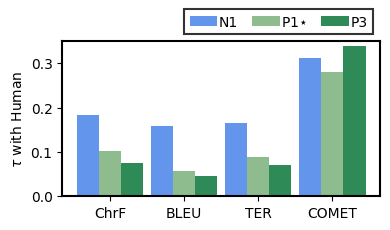

In [80]:
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import fig_utils


def corr_nice(a, b):
    return abs(kendalltau(a, b)[0])


plt.figure(figsize=(4, 2.5))
XTICKLABELS = ["ChrF", "BLEU", "TER", "COMET"]
def plot_corr(source_txt, offset_x, scores_comet, scores_bleu, scores_chrf, scores_ter, scores_human):
    plt.xticks(range(len(XTICKLABELS)), XTICKLABELS)
    plt.bar(
       np.array(range(len(XTICKLABELS)))+offset_x,
       [
          corr_nice(scores_human, scores_chrf),
          corr_nice(scores_human, scores_bleu),
          corr_nice(scores_human, scores_ter),
          corr_nice(scores_human, scores_comet),
       ],
       width=0.3,
       label=source_txt
    )
    plt.ylim(None, 0.35)
    plt.ylabel("$\\tau$ with Human")
    

plot_corr("N1", -0.3, comet_n1, bleu_n1, chrf_n1, ter_n1, human)
plot_corr("P1$\\star$", -0.0, comet_p1, bleu_p1, chrf_p1, ter_p1, human)
plot_corr("P3", +0.3, comet_p3, bleu_p3, chrf_p3, ter_p3, human)

plt.legend(
    ncol=3, fancybox=False, edgecolor="black",
    handletextpad=0.1, columnspacing=1,
    bbox_to_anchor=(1, 1.25),
    loc="upper right"
).get_frame().set_linewidth(1.5)
plt.tight_layout()
plt.savefig("figure_single.pdf")
plt.show()


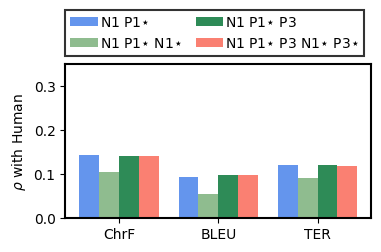

In [84]:
plt.figure(figsize=(4, 2.9))
XTICKLABELS = ["ChrF", "BLEU", "TER"]
def plot_corr(source_txt, offset_x, scores_bleu, scores_chrf, scores_ter, scores_human):
    plt.xticks(range(len(XTICKLABELS)), XTICKLABELS)
    plt.bar(
       np.array(range(len(XTICKLABELS)))+offset_x,
       [
          corr_nice(scores_human, scores_chrf),
          corr_nice(scores_human, scores_bleu),
          corr_nice(scores_human, scores_ter),
       ],
       width=0.2,
       label=source_txt
    )
    plt.ylim(None, 0.35)
    plt.ylabel("$\\rho$ with Human")

plot_corr("N1 P1$\\star$", -0.3, bleu_n1_p1s, chrf_n1_p1s, ter_n1_p1s, human)
plot_corr("N1 P1$\\star$ N1$\\star$", -0.1, bleu_n1s_p1s, chrf_n1s_p1s, ter_n1s_p1s, human)
plot_corr("N1 P1$\\star$ P3", +0.1, bleu_n1_p1s_p3, chrf_n1_p1s_p3, ter_n1_p1s_p3, human)
plot_corr("N1 P1$\\star$ P3 N1$\\star$ P3$\\star$", +0.3, bleu_n1_p1s_p3_n1s_p3s, chrf_n1_p1s_p3_n1s_p3s, ter_n1_p1s_p3_n1s_p3s, human)

plt.legend(
    ncol=2, fancybox=False, edgecolor="black",
    handletextpad=0.1, columnspacing=1,
    bbox_to_anchor=(1, 1.4),
    loc="upper right"
).get_frame().set_linewidth(1.5)
plt.tight_layout()
plt.savefig("figure_mixed.pdf")
plt.show()


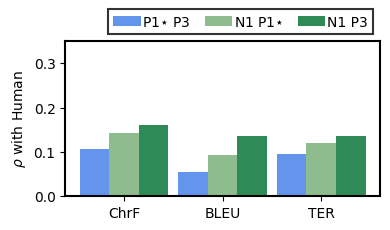

In [82]:
plt.figure(figsize=(4, 2.5))
XTICKLABELS = ["ChrF", "BLEU", "TER"]
def plot_corr(source_txt, offset_x, scores_bleu, scores_chrf, scores_ter, scores_human):
    plt.xticks(range(len(XTICKLABELS)), XTICKLABELS)
    plt.bar(
       np.array(range(len(XTICKLABELS)))+offset_x,
       [
          corr_nice(scores_human, scores_chrf),
          corr_nice(scores_human, scores_bleu),
          corr_nice(scores_human, scores_ter),
       ],
       width=0.3,
       label=source_txt
    )
    plt.ylim(None, 0.35)
    plt.ylabel("$\\rho$ with Human")

plot_corr("P1$\\star$ P3", -0.3, bleu_p1s_p3, chrf_p1s_p3, ter_p1s_p3, human)
plot_corr("N1 P1$\\star$", +0.0, bleu_n1_p1s, chrf_n1_p1s, ter_n1_p1s, human)
plot_corr("N1 P3", +0.3, bleu_n1_p3, chrf_n1_p3, ter_n1_p3, human)

plt.legend(
    ncol=3, fancybox=False, edgecolor="black",
    handletextpad=0.1, columnspacing=1,
    bbox_to_anchor=(1, 1.25),
    loc="upper right"
).get_frame().set_linewidth(1.5)
plt.tight_layout()
plt.savefig("figure_mixed_different.pdf")
plt.show()
